# MadMiner Parton-Level Analysis for $W\gamma$: Step 2 - Analysis

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import kinematic_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge


## Define Input File sample

In [8]:
usename='1M'
nsamples=500000

useinputdata = 'data/madminer_wgamma_observables_'+usename+'.h5'
usesamplesdir = 'data/samples_'+usename+'/'
usemodelsdir = 'models/samples_'+usename+'/'

## 6. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)
n_estimators = 5

#augment train sample
for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=nsamples,
        folder='./'+usesamplesdir,
        filename='train{}'.format(i)
    )

#augment test sample
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
    filename='test'
)

12:24  
12:24  ------------------------------------------------------------
12:24  |                                                          |
12:24  |  MadMiner v2018.10.30                                    |
12:24  |                                                          |
12:24  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
12:24  |                                                          |
12:24  ------------------------------------------------------------
12:24  
12:24  Loading data from data/madminer_wgamma_observables_100k.h5
12:24  Found 2 parameters:
12:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:24  Found 6 benchmarks:
12:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
12:24     morphing_basis_vector_2: CWL2 = -4.72e+01, CPWL2 = 23.25
12:24     morphing_basis_vector_3: CWL2 = 18.64, CPWL2 =

## 7. Train a neural network to estimate the score

### 7a) Change Features

In [4]:
#NN Settings
n_hidden = (100,100,100)
n_epochs = 10
batch_size = 128
initial_lr=0.002
final_lr=0.00001
myfeatures=[(0,1,2,3,4,5,6,7,8),(0,1,2,3,4,5,6,7,8,9,10,11),(12,13,14,15,16,17,18,19,20,21,22),(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22)]
myfeaturename=["mom","enmom","high","all"]

#Run NN
for ii in range(len(myfeatures)):
    #Setup ensemble
    ensemble = EnsembleForge(estimators=n_estimators)
    #train ensemble
    ensemble.train_all(
        method='sally',
        x_filename=[usesamplesdir+'x_train{}.npy'.format(i) for i in range(n_estimators)],
        t_xz0_filename=[usesamplesdir+'t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
        n_epochs=n_epochs,
        batch_size=batch_size,
        validation_split=None,
        n_hidden=n_hidden,
        initial_lr=initial_lr,
        final_lr=final_lr,
        features=myfeatures[ii]
    )
    #save ensemble
    ensemble.save(usemodelsdir+'sally_ensemble_{}'.format(myfeaturename[ii]))

12:24  Training 5 estimators in ensemble
12:24  Training estimator 1 / 5 in ensemble
12:24  Starting training
12:24    Method:                 sally
12:24    Training data: x at data/samples_100k/x_train0.npy
12:24                   t_xz (theta0) at  data/samples_100k/t_xz_train0.npy
12:24    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8)
12:24    Method:                 sally
12:24    Hidden layers:          (100, 100, 100)
12:24    Activation function:    tanh
12:24    Batch size:             128
12:24    Epochs:                 10
12:24    Learning rate:          0.002 initially, decaying to 1e-05
12:24    Validation split:       None
12:24    Early stopping:         True
12:24  Loading training data
12:24  Found 50000 samples with 2 parameters and 23 observables
12:24  Only using 9 of 23 observables
12:24  Creating model for method sally
12:24  Training model
12:24    Epoch 1: train loss 0.00 ([0.0040013])
12:24    Epoch 2: train loss 0.00 ([0.00316949])
12:24    Epoch 3: trai

12:26  Finished training
12:26  Training estimator 2 / 5 in ensemble
12:26  Starting training
12:26    Method:                 sally
12:26    Training data: x at data/samples_100k/x_train1.npy
12:26                   t_xz (theta0) at  data/samples_100k/t_xz_train1.npy
12:26    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
12:26    Method:                 sally
12:26    Hidden layers:          (100, 100, 100)
12:26    Activation function:    tanh
12:26    Batch size:             128
12:26    Epochs:                 10
12:26    Learning rate:          0.002 initially, decaying to 1e-05
12:26    Validation split:       None
12:26    Early stopping:         True
12:26  Loading training data
12:26  Found 50000 samples with 2 parameters and 23 observables
12:26  Only using 12 of 23 observables
12:26  Creating model for method sally
12:26  Training model
12:26    Epoch 1: train loss 0.00 ([0.00408737])
12:26    Epoch 2: train loss 0.00 ([0.00315225])
12:26    Epoch 3: train l

12:27    Epoch 10: train loss 0.00 ([0.0026366])
12:27  Finished training
12:27  Training estimator 3 / 5 in ensemble
12:27  Starting training
12:27    Method:                 sally
12:27    Training data: x at data/samples_100k/x_train2.npy
12:27                   t_xz (theta0) at  data/samples_100k/t_xz_train2.npy
12:27    Features:               (12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
12:27    Method:                 sally
12:27    Hidden layers:          (100, 100, 100)
12:27    Activation function:    tanh
12:27    Batch size:             128
12:27    Epochs:                 10
12:27    Learning rate:          0.002 initially, decaying to 1e-05
12:27    Validation split:       None
12:27    Early stopping:         True
12:27  Loading training data
12:27  Found 50000 samples with 2 parameters and 23 observables
12:27  Only using 11 of 23 observables
12:27  Creating model for method sally
12:27  Training model
12:27    Epoch 1: train loss 0.00 ([0.00484188])
12:27    Epoch 2: t

12:28    Epoch 6: train loss 0.00 ([0.00307822])
12:28    Epoch 7: train loss 0.00 ([0.00305411])
12:28    Epoch 8: train loss 0.00 ([0.00302777])
12:28    Epoch 9: train loss 0.00 ([0.0030152])
12:28    Epoch 10: train loss 0.00 ([0.00300611])
12:28  Finished training
12:28  Training estimator 4 / 5 in ensemble
12:28  Starting training
12:28    Method:                 sally
12:28    Training data: x at data/samples_100k/x_train3.npy
12:28                   t_xz (theta0) at  data/samples_100k/t_xz_train3.npy
12:28    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
12:28    Method:                 sally
12:28    Hidden layers:          (100, 100, 100)
12:28    Activation function:    tanh
12:28    Batch size:             128
12:28    Epochs:                 10
12:28    Learning rate:          0.002 initially, decaying to 1e-05
12:28    Validation split:       None
12:28    Early stopping:         True
12:28  Loading training dat

## 8. FisherInfo for Processed Data

In [9]:
#Setup MadFisher
fisher = FisherInformation(useinputdata, debug=False)

#Run MadFisher
fi_det_mean_all, fi_det_cov_all = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file=usemodelsdir+'sally_ensemble_all',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_high, fi_det_cov_high = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file=usemodelsdir+'sally_ensemble_high',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_mom, fi_det_cov_mom = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file=usemodelsdir+'sally_ensemble_mom',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_enmom, fi_det_cov_enmom = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file=usemodelsdir+'sally_ensemble_enmom',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)

#Run MadFisher Truth
fi_pl_full = fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)

16:38  Loading data from data/madminer_wgamma_observables_1M.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:38     morphing_basis_vector_2: CWL2 = 36.56, CPWL2 = -3.86e+01
16:38     morphing_basis_vector_3: CWL2 = -4.58e+01, CPWL2 = 36.32
16:38     morphing_basis_vector_4: CWL2 = -4.60e+01, CPWL2 = -4.27e+01
16:38     morphing_basis_vector_5: CWL2 = -1.92e+00, CPWL2 = 45.53
16:38  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva
16:38  Found 1000000 events
16:38  Found morphing setup with 6 components
16:40  Found ensemble with 5 estimators and expectations None
16:40  Evaluating Fisher informat

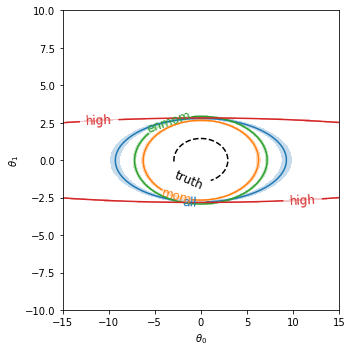

In [10]:
#Plot FisherInfo
fignn = plot_fisher_information_contours_2d(
    [fi_det_mean_all,fi_det_mean_mom,fi_det_mean_enmom,fi_det_mean_high, fi_pl_full],
    [fi_det_cov_all ,fi_det_cov_mom ,fi_det_cov_enmom ,fi_det_cov_high , None      ],
    colors=[u'C0',u'C1',u'C2',u'C3',"black"],
    linestyles=["solid","solid","solid","solid","dashed"],
    inline_labels=["all","mom","enmom","high","truth"],
    xrange=(-15.,15.),
    yrange=(-10.,10.),
)